b_s = 8 serch range = 2 QP = 1 lambda = 0.2
QP=1, lambda=0.2, large blocks=1104, sub blocks=480
b_s = 8 serch range = 2 QP = 1 lambda = 0.5
QP=1, lambda=0.5, large blocks=1221, sub blocks=363
b_s = 8 serch range = 2 QP = 1 lambda = 0.85
QP=1, lambda=0.85, large blocks=1260, sub blocks=324
b_s = 8 serch range = 2 QP = 1 lambda = 3
QP=1, lambda=3, large blocks=1285, sub blocks=299
b_s = 8 serch range = 2 QP = 3 lambda = 0.2
QP=3, lambda=0.2, large blocks=1214, sub blocks=370
b_s = 8 serch range = 2 QP = 3 lambda = 0.5
QP=3, lambda=0.5, large blocks=1293, sub blocks=291
b_s = 8 serch range = 2 QP = 3 lambda = 0.85
QP=3, lambda=0.85, large blocks=1343, sub blocks=241
b_s = 8 serch range = 2 QP = 3 lambda = 3
QP=3, lambda=3, large blocks=1431, sub blocks=153
b_s = 8 serch range = 2 QP = 5 lambda = 0.2
QP=5, lambda=0.2, large blocks=1187, sub blocks=397
b_s = 8 serch range = 2 QP = 5 lambda = 0.5
QP=5, lambda=0.5, large blocks=1246, sub blocks=338
b_s = 8 serch range = 2 QP = 5 lambda = 0.85

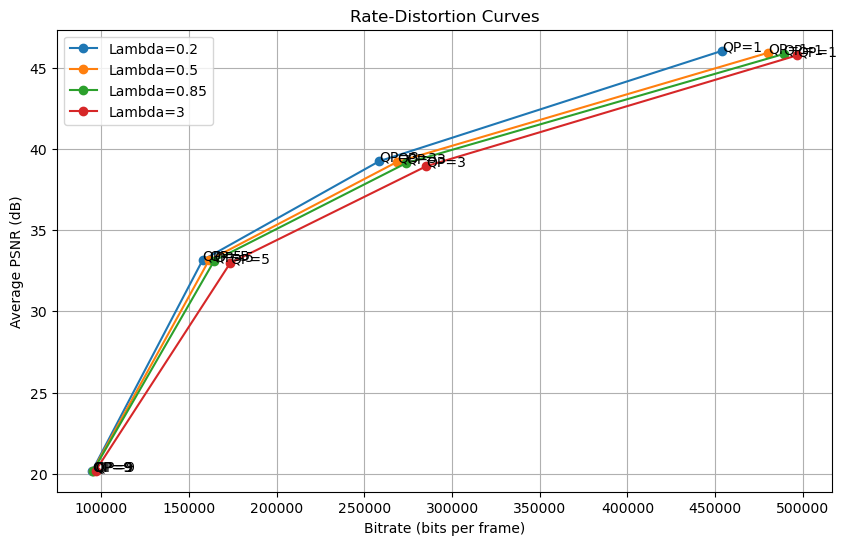

In [ ]:
import numpy as np
import math
import time
import os
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

def visualize_oneframe(Y_frame, frame_number):

    plt.imshow(Y_frame, cmap='gray', vmin=0, vmax=255)
    plt.title(f'Frame {frame_number}')
    plt.axis('off')
    plt.show()

def read_yuv420_file(filename, width, height, num_frames):
    """
    Read YUV420 file and extract Y frames.
    Returns a list of Y frames as numpy arrays.
    """
    frame_size = width * height * 3 // 2  # YUV420
    Y_frames = []

    with open(filename, 'rb') as f:
        for i in range(num_frames):
            raw = f.read(frame_size)
            if len(raw) < frame_size:
                print("Reached end of file at frame", i)
                break
            # Y component
            Y = np.frombuffer(raw[0:width*height], dtype=np.uint8)
            Y = Y.reshape((height, width))
            Y_frames.append(Y)
            # U and V components are ignored
    return Y_frames

def write_y_only_file(filename, Y_frames):
    """
    Writes Y frames into a Y-only file.
    """
    with open(filename, 'wb') as f:
        for Y in Y_frames:
            f.write(Y.tobytes())

def split_frame_into_blocks(Y_frame, block_size, pad_value=128):
    """
    Splits a Y frame into blocks of size block_size x block_size, with padding if necessary.
    Returns a list of blocks and their coordinates (top-left corner).
    """
    height, width = Y_frame.shape
    # Calculate padding needed
    pad_height = (block_size - (height % block_size)) % block_size
    pad_width = (block_size - (width % block_size)) % block_size

    # Pad the frame
    Y_padded = np.pad(Y_frame, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=pad_value)

    blocks = []
    coordinates = []
    padded_height, padded_width = Y_padded.shape

    for y in range(0, padded_height, block_size):
        for x in range(0, padded_width, block_size):
            block = Y_padded[y:y+block_size, x:x+block_size]
            blocks.append(block)
            coordinates.append((y, x))
    return blocks, coordinates, Y_padded

def motion_estimation(current_block, current_y, current_x, ref_frame, search_range, block_size):
    """
    Performs motion estimation for a single block.
    Returns the best match block, motion vector, and minimum MAE.
    """
    height, width = ref_frame.shape
    min_mae = None
    best_mv = (0, 0)
    best_match_block = None

    # Search window boundaries
    y_start = max(current_y - search_range, 0)
    y_end = min(current_y + search_range, height - block_size)
    x_start = max(current_x - search_range, 0)
    x_end = min(current_x + search_range, width - block_size)

    # Ensure the search window is valid
    if y_end < y_start:
        y_end = y_start
    if x_end < x_start:
        x_end = x_start

    for ref_y in range(y_start, y_end + 1):
        for ref_x in range(x_start, x_end + 1):
            # Check if the candidate block fits within the frame
            if ref_y + block_size <= height and ref_x + block_size <= width:
                ref_block = ref_frame[ref_y:ref_y+block_size, ref_x:ref_x+block_size]
                mae = np.mean(np.abs(current_block.astype(np.int16) - ref_block.astype(np.int16)))
                mv_y = ref_y - current_y
                mv_x = ref_x - current_x
                l1_norm = abs(mv_y) + abs(mv_x)
                if min_mae is None or mae < min_mae:
                    min_mae = mae
                    best_mv = (mv_y, mv_x)
                    best_match_block = ref_block
                elif mae == min_mae:
                    # Tie-breaking rules
                    current_l1_norm = abs(best_mv[0]) + abs(best_mv[1])
                    if l1_norm < current_l1_norm:
                        best_mv = (mv_y, mv_x)
                        best_match_block = ref_block
                    elif l1_norm == current_l1_norm:
                        if mv_y < best_mv[0]:
                            best_mv = (mv_y, mv_x)
                            best_match_block = ref_block
                        elif mv_y == best_mv[0]:
                            if mv_x < best_mv[1]:
                                best_mv = (mv_y, mv_x)
                                best_match_block = ref_block
            else:
                # Skip the reference candidate block if it doesn't fit within the frame
                continue

    # Handle the case where no candidate blocks were evaluated
    if min_mae is None:
        # No candidates were found; use the current block as the best match
        min_mae = 0
        best_mv = (0, 0)
        best_match_block = current_block

    return best_match_block, best_mv, min_mae

def motion_estimation_frame(current_blocks, coordinates, ref_frame, search_range, block_size):
    """
    Performs motion estimation for all blocks in the current frame.
    Returns predicted blocks, motion vectors, MAE values, and average MAE.
    """
    predicted_blocks = []
    motion_vectors = []
    mae_values = []
    total_mae = 0

    for block, (y, x) in zip(current_blocks, coordinates):
        best_match_block, mv, mae = motion_estimation(block, y, x, ref_frame, search_range, block_size)
        predicted_blocks.append(best_match_block)
        motion_vectors.append(mv)
        mae_values.append(mae)
        total_mae += mae
    average_mae = total_mae / len(current_blocks)
    return predicted_blocks, motion_vectors, mae_values, average_mae

def apply_2d_dct(block):
    # Apply DCT along rows first
    dct_rows = dct(block, axis=0, norm='ortho')
    # Apply DCT along columns next
    dct_2d = dct(dct_rows, axis=1, norm='ortho')
    return dct_2d

def apply_inverse_2d_dct(block):
    # Apply inverse DCT along columns first
    idct_cols = idct(block, axis=1, norm='ortho')
    # Apply inverse DCT along rows next
    idct_2d = idct(idct_cols, axis=0, norm='ortho')
    return idct_2d

def quantize(block, QP):
    i = block.shape[0]
    Q = np.zeros((i, i))
    for x in range(i):
        for y in range(i):
            if x + y < i - 1:
                Q[x, y] = 2 ** QP
            elif x + y == i - 1:
                Q[x, y] = 2 ** (QP + 1)
            else:
                Q[x, y] = 2 ** (QP + 2)
    return np.round(block / Q).astype(np.int16)

def inverse_quantize(block, QP):
    i = block.shape[0]
    Q = np.zeros((i, i))
    for x in range(i):
        for y in range(i):
            if x + y < i - 1:
                Q[x, y] = 2 ** QP
            elif x + y == i - 1:
                Q[x, y] = 2 ** (QP + 1)
            else:
                Q[x, y] = 2 ** (QP + 2)
    return (block * Q).astype(np.float32)

def save_residuals(residuals, coordinates, filename):
    """
    Saves residuals and their coordinates to a file.
    """
    with open(filename, 'w') as f:
        for (y, x), residual in zip(coordinates, residuals):
            # Flatten the residual block
            residual_flat = residual.flatten()
            residual_str = ' '.join(map(str, residual_flat))
            f.write(f"{y} {x} {residual_str}\n")

def load_residuals(coordinates, block_size, filename):
    """
    Loads residuals from a file and reconstructs the list of residual blocks.
    """
    residuals = []
    with open(filename, 'r') as f:
        for line in f:
            tokens = line.strip().split()
            y, x = int(tokens[0]), int(tokens[1])
            residual_values = list(map(int, tokens[2:]))
            residual_block = np.array(residual_values, dtype=np.int16).reshape((block_size, block_size))
            residuals.append(residual_block)
    return residuals

def reconstruct_blocks(predicted_blocks, residuals):
    """
    Reconstructs blocks by adding residuals to predicted blocks.
    Returns a list of reconstructed blocks.
    """
    reconstructed_blocks = []
    for predicted_block, residual in zip(predicted_blocks, residuals):
        reconstructed_block = predicted_block.astype(np.float32) + residual
        # Clip to 0-255
        reconstructed_block = np.clip(reconstructed_block, 0, 255).astype(np.uint8)
        reconstructed_blocks.append(reconstructed_block)
    return reconstructed_blocks

def assemble_frame_from_blocks(blocks, coordinates, padded_height, padded_width):
    """
    Assembles the frame from blocks and coordinates.
    Returns the assembled frame with padding.
    """
    reconstructed_frame = np.zeros((padded_height, padded_width), dtype=np.uint8)
    for block, (y, x) in zip(blocks, coordinates):
        reconstructed_frame[y:y+block.shape[0], x:x+block.shape[1]] = block
    return reconstructed_frame

def remove_padding(frame_padded, original_height, original_width):
    """
    Removes padding from the reconstructed frame.
    """
    return frame_padded[:original_height, :original_width]

def compute_psnr(original_frame, reconstructed_frame):
    """
    Computes the Peak Signal-to-Noise Ratio between the original and reconstructed frames.
    """
    mse = np.mean((original_frame.astype(np.float32) - reconstructed_frame.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')  # No error, infinite PSNR
    psnr = 10 * np.log10((255 ** 2) / mse)
    return psnr

def save_motion_vectors_differential(motion_vectors, coordinates, block_size, filename):
    """
    Saves differential motion vectors and their coordinates to a file.
    """
    mv_diff = []
    with open(filename, 'w') as f:
        previous_mv = (0, 0)
        previous_row = -1
        for (y, x), (mv_y, mv_x) in zip(coordinates, motion_vectors):
            current_row = y // block_size
            if current_row != previous_row:
                # New row, reset previous_mv to (0, 0)
                previous_mv = (0, 0)
                previous_row = current_row

            diff_mv_y = mv_y - previous_mv[0]
            diff_mv_x = mv_x - previous_mv[1]
            f.write(f"{y} {x} {diff_mv_y} {diff_mv_x}\n")
            previous_mv = (mv_y, mv_x)
            mv_diff.append((diff_mv_y, diff_mv_x))
            
    return mv_diff

def save_motion_vectors_differential(motion_vectors, coordinates, block_size, filename):
    """
    Saves differential motion vectors and their coordinates to a file.
    """
    mv_diff = []
    with open(filename, 'w') as f:
        previous_mv = (0, 0)
        previous_row = -1
        for (y, x), (mv_y, mv_x) in zip(coordinates, motion_vectors):
            current_row = y // block_size
            if current_row != previous_row:
                # New row, reset previous_mv to (0, 0)
                previous_mv = (0, 0)
                previous_row = current_row

            diff_mv_y = mv_y - previous_mv[0]
            diff_mv_x = mv_x - previous_mv[1]
            f.write(f"{y} {x} {diff_mv_y} {diff_mv_x}\n")
            previous_mv = (mv_y, mv_x)
            mv_diff.append((diff_mv_y, diff_mv_x))
            
    return mv_diff

def save_modes_differential(selected_modes, coordinates, block_size, filename):
    """
    Saves differential intra prediction modes and their coordinates to a file.
    """
    modes_diff = []
    with open(filename, 'w') as f:
        previous_mode = 0  # Assume Horizontal mode (0) as default
        previous_row = -1
        for (y, x), mode in zip(coordinates, selected_modes):
            current_row = y // block_size
            if current_row != previous_row:
                previous_mode = 0
                previous_row = current_row

            diff_mode = mode - previous_mode
            f.write(f"{y} {x} {diff_mode}\n")
            modes_diff.append(diff_mode)
            previous_mode = mode
        
    return modes_diff

def load_modes_differential(coordinates, block_size, filename):
    """
    Loads differential intra prediction modes from a file and reconstructs the modes.
    """
    selected_modes = []
    previous_mode = 0  # Assume Horizontal mode (0) as default
    previous_row = -1

    with open(filename, 'r') as f:
        for line in f:
            y_str, x_str, diff_mode_str = line.strip().split()
            y, x = int(y_str), int(x_str)
            diff_mode = int(diff_mode_str)

            current_row = y // block_size
            if current_row != previous_row:
                previous_mode = 0
                previous_row = current_row

            mode = (previous_mode + diff_mode) % 2
            selected_modes.append(mode)
            previous_mode = mode
    return selected_modes

def intra_prediction(current_block, reconstructed_frame, y, x, block_size):
    """
    Performs intra prediction for a single block.
    Returns the predicted block and the selected mode (0 for horizontal, 1 for vertical).
    """
    # Get neighboring pixels from reconstructed_frame
    if x > 0:
        # Left column is reconstructed_frame[y:y+block_size, x - 1]
        left_column = reconstructed_frame[y:y+block_size, x - 1]
    else:
        # Use 128 for left column
        left_column = np.full((block_size,), 128, dtype=np.int16)

    horizontal_pred = np.tile(left_column.reshape(-1, 1), (1, block_size))

    if y > 0:
        # Above row is reconstructed_frame[y - 1, x:x+block_size]
        above_row = reconstructed_frame[y - 1, x:x+block_size]
    else:
        # Use 128 for above row
        above_row = np.full((block_size,), 128, dtype=np.int16)

    vertical_pred = np.tile(above_row.reshape(1, -1), (block_size, 1))

    # Compute MAE for both modes
    mae_horizontal = np.mean(np.abs(current_block.astype(np.int16) - horizontal_pred))
    mae_vertical = np.mean(np.abs(current_block.astype(np.int16) - vertical_pred))

    # Select mode with lowest MAE
    if mae_horizontal <= mae_vertical:
        selected_mode = 0  # Horizontal
        predicted_block = horizontal_pred
    else:
        selected_mode = 1  # Vertical
        predicted_block = vertical_pred

    return predicted_block, selected_mode

# def zigzag_order(block):
#     N = block.shape[0]
#     result = []
#     for sum_index in range(2 * N - 1):
#         if sum_index % 2 == 0:
#             for i in range(max(0, sum_index - N + 1), min(N, sum_index + 1)):
#                 result.append(block[i, sum_index - i])
#         else:
#             for i in range(max(0, sum_index - N + 1), min(N, sum_index + 1)):
#                 result.append(block[sum_index - i, i])
#     return np.array(result)

def diagonal_order(block):
    N = block.shape[0]  # Assume square block
    result = []

    # start from (0, 0)
    for sum_index in range(2 * N - 1):
        for i in range(max(0, sum_index - N + 1), min(sum_index + 1, N)):
            result.append(block[i, sum_index - i])  #top-right to bottom-left

    return np.array(result)


def run_length_encode(coefficients):
    encoded = []
    count = 0
    for value in coefficients:
        if value == 0:
            count += 1
        else:
            if count > 0:
                encoded.append(count)  # Positive count indicates the number of zeros
                count = 0
            encoded.append(-1)  # -1 indicates a non-zero value follows
            encoded.append(value)
    if count > 0:
        encoded.append(count)  # Trailing zeros
    return encoded

def exp_golomb_code(value):
    if value == 0:
        return '0'
    
    magnitude = abs(value)
    binary = bin(magnitude)[2:]  # Binary representation without '0b'
    prefix = '0' * (len(binary) - 1)
    code_word = prefix + binary
    
    # Handle sign for negative values
    if value < 0:
        code_word = '1' + code_word[1:]  # Flip the most significant bit
    return code_word

def entropy_encode_frame(frame_type, intra_modes, motion_vectors, quantized_blocks):
    encoded_stream = []
    
    # Frame type marker (1 for I-frame, 0 for P-frame)
    encoded_stream.append(exp_golomb_code(frame_type))
    
    if frame_type == 1:  # I-frame
        # Encode Intra Prediction Modes
        for mode in intra_modes:
            encoded_stream.append(exp_golomb_code(mode))
    elif frame_type == 0:  # P-frame
        # Encode Motion Vectors
        for mv_x, mv_y in motion_vectors:
            encoded_stream.append(exp_golomb_code(mv_x))
            encoded_stream.append(exp_golomb_code(mv_y))
    
    # Encode Quantized Transform Coefficients
    for block in quantized_blocks:
        reordered_coeffs = diagonal_order(block)
        rle_encoded = run_length_encode(reordered_coeffs)
        for value in rle_encoded:
            encoded_stream.append(exp_golomb_code(value))
    
    return encoded_stream

# Bit calcu for dicision making VBS
def entropy_encode_block(frame_type, mode_or_mv, quantized_block):
    total_bits = 0

    # Encode mode or motion vector
    if frame_type == 1:  # I-frame
        mode_bits = len(exp_golomb_code(mode_or_mv))
        total_bits += mode_bits
    else:  # P-frame
        mv_x_bits = len(exp_golomb_code(mode_or_mv[0]))
        mv_y_bits = len(exp_golomb_code(mode_or_mv[1]))
        total_bits += mv_x_bits + mv_y_bits

    # Encode quantized coefficients
    reordered_coeffs = diagonal_order(quantized_block)
    rle_encoded = run_length_encode(reordered_coeffs)
    for value in rle_encoded:
        coeff_bits = len(exp_golomb_code(value))
        total_bits += coeff_bits

    return total_bits

def VBS_process_I(current_block, Y_frame, y, x, block_size, QP, reconstructed_frame_padded,
                  selected_modes, lambda_value, quantized_blocks, occupancy_map, modes_diff):
    
    idx = len(selected_modes)  # Start index for blocks

    # Predictor mode initialization
    predictor_mode = 0
    neighbor_modes = []

    # Check for left neighbor
    if x > 0:
        left_x = x - 1
        neighbor_idx = occupancy_map[y, left_x]
        if neighbor_idx != -1:
            predictor_mode = selected_modes[neighbor_idx]
            neighbor_modes.append(predictor_mode)

    # Check for above neighbor
    if y > 0:
        above_y = y - 1
        neighbor_idx = occupancy_map[above_y, x]
        if neighbor_idx != -1:
            predictor_mode = selected_modes[neighbor_idx]
            neighbor_modes.append(predictor_mode)

    if neighbor_modes:
        predictor_mode = neighbor_modes[0]
    else:
        predictor_mode = 0

    # Perform intra prediction for the large block
    predicted_block_large, selected_mode_large = intra_prediction(
        current_block, reconstructed_frame_padded, y, x, block_size)
    residual_large = current_block.astype(np.int16) - predicted_block_large.astype(np.int16)
    dct_residual_large = apply_2d_dct(residual_large)
    quantized_residual_large = quantize(dct_residual_large, QP=QP)
    dequantized_large = inverse_quantize(quantized_residual_large, QP=QP)
    approx_residual_large = apply_inverse_2d_dct(dequantized_large)
    reconstructed_large = np.clip(predicted_block_large + approx_residual_large, 0, 255).astype(np.uint8)

    # Calculate RD cost for the large block
    distortion_large = np.sum(np.abs(current_block.astype(np.int16) - reconstructed_large.astype(np.int16)))
    rate_large = entropy_encode_block(1, selected_mode_large, quantized_residual_large)
    rd_cost_large = distortion_large + lambda_value * rate_large

    # Perform intra prediction for sub-blocks
    sub_block_size = block_size // 2
    sub_blocks, sub_coords, _ = split_frame_into_blocks(current_block, sub_block_size)
    sub_rd_cost = 0

    for sub_idx, sub_block in enumerate(sub_blocks):
        sub_y, sub_x = y + (sub_idx // 2) * sub_block_size, x + (sub_idx % 2) * sub_block_size

        # Check for neighbors for the sub-block
        sub_predictor_mode = 0
        neighbor_modes = []

        if sub_x > 0:
            left_x = sub_x - 1
            neighbor_idx = occupancy_map[sub_y, left_x]
            if neighbor_idx != -1:
                sub_predictor_mode = selected_modes[neighbor_idx]
                neighbor_modes.append(sub_predictor_mode)

        if sub_y > 0:
            above_y = sub_y - 1
            neighbor_idx = occupancy_map[above_y, sub_x]
            if neighbor_idx != -1:
                sub_predictor_mode = selected_modes[neighbor_idx]
                neighbor_modes.append(sub_predictor_mode)

        if neighbor_modes:
            sub_predictor_mode = neighbor_modes[0]
        else:
            sub_predictor_mode = 0

        # Intra prediction for the sub-block
        sub_pred, sub_mode = intra_prediction(sub_block, reconstructed_frame_padded, sub_y, sub_x, sub_block_size)
        sub_residual = sub_block.astype(np.int16) - sub_pred.astype(np.int16)
        sub_dct = apply_2d_dct(sub_residual)
        sub_quantized = quantize(sub_dct, QP=QP)
        sub_dequantized = inverse_quantize(sub_quantized, QP=QP)
        sub_approx = apply_inverse_2d_dct(sub_dequantized)
        sub_reconstructed = np.clip(sub_pred + sub_approx, 0, 255).astype(np.uint8)

        # RD cost for the sub-block
        sub_distortion = np.sum(np.abs(sub_block.astype(np.int16) - sub_reconstructed.astype(np.int16)))
        sub_rate = entropy_encode_block(1, sub_mode, sub_quantized)
        sub_rd_cost += sub_distortion + lambda_value * sub_rate

        # Calculate differential mode for the sub-block
        sub_diff_mode = (sub_mode - sub_predictor_mode) % 2  # Assuming two modes (0 and 1)
        modes_diff.append(sub_diff_mode)

        # Update selected modes and quantized blocks immediately
        selected_modes.append(sub_mode)
        quantized_blocks.append(sub_quantized)

        # Update reconstructed frame
        reconstructed_frame_padded[sub_y:sub_y+sub_block_size, sub_x:sub_x+sub_block_size] = sub_reconstructed

        # Update occupancy_map
        occupancy_map[sub_y:sub_y+sub_block_size, sub_x:sub_x+sub_block_size] = idx
        idx += 1  # Increment idx after adding each sub-block

    # Decide whether to split the block
    if sub_rd_cost < rd_cost_large:
        split_flag = 1
    else:
        split_flag = 0
        # Use the large block
        diff_mode_large = (selected_mode_large - predictor_mode) % 2
        modes_diff.append(diff_mode_large)
        selected_modes.append(selected_mode_large)
        quantized_blocks.append(quantized_residual_large)

        # Update reconstructed frame
        reconstructed_frame_padded[y:y+block_size, x:x+block_size] = reconstructed_large

        # Update occupancy_map
        occupancy_map[y:y+block_size, x:x+block_size] = idx
        idx += 1

    return split_flag

def VBS_process_P(current_blocks, coordinates, ref_frame, search_range, block_size, QP, motion_vectors, quantized_blocks,
                  lambda_value, reconstructed_frame_padded, occupancy_map, mv_diffs):

    sub_count = 0
    large_count = 0
    split_flags = []
    idx = len(motion_vectors)  # Start index for blocks

    for idx_block, ((y, x), current_block) in enumerate(zip(coordinates, current_blocks)):
        predictor_mv = (0, 0)
        neighbor_mvs = []

        # Check for left neighbor
        if x > 0:
            left_x = x - 1
            neighbor_idx = occupancy_map[y, left_x]
            if neighbor_idx != -1:
                predictor_mv = motion_vectors[neighbor_idx]
                neighbor_mvs.append(predictor_mv)

        # Check for above neighbor
        if y > 0:
            above_y = y - 1
            neighbor_idx = occupancy_map[above_y, x]
            if neighbor_idx != -1:
                predictor_mv = motion_vectors[neighbor_idx]
                neighbor_mvs.append(predictor_mv)

        if neighbor_mvs:
            predictor_mv = neighbor_mvs[0]
        else:
            predictor_mv = (0, 0)

        # Perform motion estimation for the large block
        predicted_large, mv_large, _ = motion_estimation(
            current_block, y, x, ref_frame, search_range, block_size)
        residual_large = current_block.astype(np.int16) - predicted_large.astype(np.int16)
        dct_residual_large = apply_2d_dct(residual_large)
        quantized_large = quantize(dct_residual_large, QP=QP)
        dequantized_large = inverse_quantize(quantized_large, QP=QP)
        approx_residual_large = apply_inverse_2d_dct(dequantized_large)
        reconstructed_large = np.clip(predicted_large + approx_residual_large, 0, 255).astype(np.uint8)

        # RD cost for the large block
        distortion_large = np.sum(np.abs(current_block.astype(np.int16) - reconstructed_large.astype(np.int16)))
        rate_large = entropy_encode_block(0, mv_large, quantized_large)
        rd_cost_large = distortion_large + lambda_value * rate_large

        # Perform motion estimation for sub-blocks
        sub_block_size = block_size // 2
        sub_blocks, sub_coords, _ = split_frame_into_blocks(current_block, sub_block_size)
        sub_rd_cost = 0

        for sub_idx, sub_block in enumerate(sub_blocks):
            sub_y, sub_x = y + (sub_idx // 2) * sub_block_size, x + (sub_idx % 2) * sub_block_size

            # Check for neighbors for the sub-block
            sub_predictor_mv = (0, 0)
            neighbor_mvs = []

            if sub_x > 0:
                left_x = sub_x - 1
                neighbor_idx = occupancy_map[sub_y, left_x]
                if neighbor_idx != -1:
                    sub_predictor_mv = motion_vectors[neighbor_idx]
                    neighbor_mvs.append(sub_predictor_mv)

            if sub_y > 0:
                above_y = sub_y - 1
                neighbor_idx = occupancy_map[above_y, sub_x]
                if neighbor_idx != -1:
                    sub_predictor_mv = motion_vectors[neighbor_idx]
                    neighbor_mvs.append(sub_predictor_mv)

            if neighbor_mvs:
                sub_predictor_mv = neighbor_mvs[0]
            else:
                sub_predictor_mv = (0, 0)

            # Motion estimation for the sub-block
            sub_pred, sub_mv, _ = motion_estimation(
                sub_block, sub_y, sub_x, ref_frame, search_range, sub_block_size)
            sub_residual = sub_block.astype(np.int16) - sub_pred.astype(np.int16)
            sub_dct = apply_2d_dct(sub_residual)
            sub_quantized = quantize(sub_dct, QP=QP)
            sub_dequantized = inverse_quantize(sub_quantized, QP=QP)
            sub_approx = apply_inverse_2d_dct(sub_dequantized)
            sub_reconstructed = np.clip(sub_pred + sub_approx, 0, 255).astype(np.uint8)

            # RD cost for the sub-block
            sub_distortion = np.sum(np.abs(sub_block.astype(np.int16) - sub_reconstructed.astype(np.int16)))
            sub_rate = entropy_encode_block(0, sub_mv, sub_quantized)
            sub_rd_cost += sub_distortion + lambda_value * sub_rate

            # Calculate differential motion vector for the sub-block
            diff_mv_y = sub_mv[0] - sub_predictor_mv[0]
            diff_mv_x = sub_mv[1] - sub_predictor_mv[1]
            mv_diffs.append((diff_mv_y, diff_mv_x))

            # Update motion vectors and quantized blocks immediately
            motion_vectors.append(sub_mv)
            quantized_blocks.append(sub_quantized)

            # Update reconstructed frame
            reconstructed_frame_padded[sub_y:sub_y+sub_block_size, sub_x:sub_x+sub_block_size] = sub_reconstructed

            # Update occupancy_map
            occupancy_map[sub_y:sub_y+sub_block_size, sub_x:sub_x+sub_block_size] = idx
            idx += 1  # Increment idx after adding each sub-block

        # Decide whether to split the block
        if sub_rd_cost < rd_cost_large:
            split_flag = 1
            sub_count += 1
        else:
            split_flag = 0
            # Use the large block
            diff_mv_y = mv_large[0] - predictor_mv[0]
            diff_mv_x = mv_large[1] - predictor_mv[1]
            mv_diffs.append((diff_mv_y, diff_mv_x))
            motion_vectors.append(mv_large)
            quantized_blocks.append(quantized_large)

            # Update reconstructed frame
            reconstructed_frame_padded[y:y+block_size, x:x+block_size] = reconstructed_large

            # Update occupancy_map
            occupancy_map[y:y+block_size, x:x+block_size] = idx
            idx += 1
            large_count += 1

        split_flags.append(exp_golomb_code(split_flag))

    return split_flags, sub_count, large_count


def process_frames(Y_frames, block_size, search_range, I_Period, QP_values, 
                   lambda_values, num_frames=10, VBSEnable = False):

    rd_results = []

    for QP in QP_values:
        #add loop for diff lambda test
        for lambda_value in lambda_values:
            print(f"b_s = {block_size} serch range = {search_range} QP = {QP} lambda = {lambda_value}")
            reconstructed_prev_frame = None
            reconstructed_frames = []
            per_frame_mae = []
            per_frame_psnr = []
            total_bit_size = 0
            frame_bit_sizes = []
            split_flags = []
            sub_count = 0
            large_count = 0
            
            # Start timing the encoding process
            start_time = time.time()
            
            for frame_idx in range(num_frames):
                Y_frame = Y_frames[frame_idx]
                current_blocks, coordinates, Y_padded = split_frame_into_blocks(Y_frame, block_size)
                padded_height, padded_width = Y_padded.shape
                occupancy_map = np.full((padded_height, padded_width), -1, dtype=int)

                if frame_idx % I_Period == 0:
                    # I-frame: perform intra prediction
                    # print(f"Processing I-frame {frame_idx} with QP={QP}, Block size={block_size}")
                    selected_modes = []
                    quantized_blocks = []
                    modes_diff = []
                    reconstructed_frame_padded = np.zeros((padded_height, padded_width), dtype=np.uint8)
     
                    for idx, ((y, x), current_block) in enumerate(zip(coordinates, current_blocks)):
                        #VBS ON/OFF
                        if VBSEnable:
                            split_flag = \
                            VBS_process_I(current_block, Y_frame, y, x, block_size, QP, reconstructed_frame_padded,
                                        selected_modes, lambda_value, quantized_blocks, occupancy_map, modes_diff)
                            if split_flag == 1:
                                sub_count += 1
                            else:
                                large_count += 1
                            split_flags.append(exp_golomb_code(split_flag))
                        else:
                            predicted_block, selected_mode = intra_prediction(current_block, reconstructed_frame_padded, 
                                                                            y, x, block_size)
                            residual = current_block.astype(np.int16) - predicted_block.astype(np.int16)
                            dct_residual = apply_2d_dct(residual)
                            quantized_residual = quantize(dct_residual, QP=QP)
                            quantized_blocks.append(quantized_residual)
                            selected_modes.append(selected_mode)
                            dequantized_residual = inverse_quantize(quantized_residual, QP=QP)
                            approx_residual = apply_inverse_2d_dct(dequantized_residual)
                            reconstructed_block = predicted_block.astype(np.float32) + approx_residual
                            reconstructed_block = np.clip(reconstructed_block, 0, 255).astype(np.uint8)
                            reconstructed_frame_padded[y:y+block_size, x:x+block_size] = reconstructed_block
                            mode_filename = f"modes_block{block_size}_frame{frame_idx}.txt"
                            modes_diff = save_modes_differential(selected_modes, coordinates, block_size, mode_filename)
                    
                    reconstructed_frame = remove_padding(reconstructed_frame_padded, Y_frame.shape[0], Y_frame.shape[1])
                    reconstructed_prev_frame = reconstructed_frame
                    encoded_stream = entropy_encode_frame(1, modes_diff, [], quantized_blocks)
                    # print("Encoded stream I:", encoded_stream)
                    frame_bit_size = sum(len(value) for value in encoded_stream)
                    frame_bit_sizes.append(frame_bit_size)
                    split_flag_bits = sum(len(value) for value in split_flags)
                    total_bit_size += frame_bit_size + split_flag_bits
                    reconstructed_frames.append(reconstructed_frame)

                # P-frame: perform motion estimation
                else:
                    motion_vectors = []
                    quantized_blocks = []
                    reconstructed_blocks = []
                    mv_diff = []
                    ref_frame = reconstructed_prev_frame
                    
                    reconstructed_frame_padded = np.zeros((padded_height, padded_width), dtype=np.uint8)
                    sub_count = 0
                    large_count = 0
                    # visualize_oneframe(ref_frame, f"Ref {frame_idx}")
                    # residual_frame = np.zeros_like(Y_padded, dtype=np.int16)  # Initialize residual frame
                    
                    # print(f"Processing P-frame {frame_idx} with QP={QP}, Block size={block_size}")
                    if VBSEnable:
                        split_flags, sub_count_p, large_count_p = \
                        VBS_process_P(current_blocks, coordinates, ref_frame, search_range, block_size, QP, 
                                    motion_vectors, quantized_blocks, 
                                    lambda_value, reconstructed_frame_padded, occupancy_map, mv_diff)
                        sub_count += sub_count_p
                        large_count += large_count_p
                        
                    ## Same as before
                    else: 
                        predicted_blocks, motion_vectors, mae_values, average_mae = motion_estimation_frame(
                            current_blocks, coordinates, ref_frame, search_range, block_size)

                        for current_block, predicted_block in zip(current_blocks, predicted_blocks):
                            residual = current_block.astype(np.int16) - predicted_block.astype(np.int16)
                            dct_residual = apply_2d_dct(residual)
                            quantized_residual = quantize(dct_residual, QP=QP)
                            quantized_blocks.append(quantized_residual)
                            dequantized_residual = inverse_quantize(quantized_residual, QP=QP)
                            approx_residual = apply_inverse_2d_dct(dequantized_residual)
                            reconstructed_block = predicted_block.astype(np.float32) + approx_residual
                            reconstructed_block = np.clip(reconstructed_block, 0, 255).astype(np.uint8)
                            reconstructed_blocks.append(reconstructed_block)
                            
                        reconstructed_frame_padded = assemble_frame_from_blocks(
                            reconstructed_blocks, coordinates, padded_height, padded_width)
                        mv_filename = f"mv_block{block_size}_range{search_range}_frame{frame_idx}.txt"
                        mv_diff = save_motion_vectors_differential(motion_vectors, coordinates, block_size, mv_filename)

                    encoded_stream = entropy_encode_frame(0, [], mv_diff, quantized_blocks)
                    # print("Encoded stream P:", encoded_stream)
                    reconstructed_frame = remove_padding(reconstructed_frame_padded, Y_frame.shape[0], Y_frame.shape[1])
                    reconstructed_prev_frame = reconstructed_frame
                    
                    # visualize_oneframe(Y_padded, f"Current Frame {frame_idx}")
                    # visualize_oneframe(np.clip(residual_frame, -255, 255).astype(np.uint8) + 128, frame_idx)
                          
                    frame_bit_size = sum(len(value) for value in encoded_stream)
                    frame_bit_sizes.append(frame_bit_size)
                    split_flag_bits = sum(len(value) for value in split_flags)
                    total_bit_size += frame_bit_size + split_flag_bits
                    reconstructed_frames.append(reconstructed_frame)

                # Calculate PSNR and MAE for each frame
                psnr = compute_psnr(Y_frame, reconstructed_frame)
                per_frame_psnr.append(psnr)
                total_mae = sum([np.mean(np.abs(current_block.astype(np.int16) - reconstructed_frame_padded[y:y+block_size, x:x+block_size].astype(np.int16)))
                                for (y, x), current_block in zip(coordinates, current_blocks)])
                average_mae = total_mae / len(current_blocks)
                per_frame_mae.append(average_mae)
                
                # visualize_oneframe(Y_frame, frame_idx)
                # visualize_oneframe(reconstructed_frames[frame_idx], frame_idx)

            print(f'QP={QP}, lambda={lambda_value}, large blocks={large_count}, sub blocks={sub_count}')
            # End timing the encoding process
            end_time = time.time()
            encoding_time = end_time - start_time
            average_psnr = np.mean(per_frame_psnr)
            bitrate = total_bit_size / num_frames
            
            rd_results.append({
                "QP": QP,
                "lambda": lambda_value,
                "block_size": block_size,
                "I_Period": I_Period,
                "total_bit_size": total_bit_size,
                "average_psnr": average_psnr,
                "bitrate": bitrate,
                "frame_bit_sizes": frame_bit_sizes,
                "encoding_time": encoding_time
            })
            
    # for frame_idx in range(num_frames):
    #     visualize_oneframe(Y_frame, frame_idx)
    #     visualize_oneframe(reconstructed_frames[frame_idx], frame_idx)

    return rd_results

def run_experiments(Y_frames, num_frames):
    block_sizes = [8, 16]
    search_range = 2
    I_Period_values = [1, 4, 10]
    QP_values_dict = {8: [0, 3, 6, 9], 16: [1, 4, 7, 10]}

    all_results = []

    for block_size in block_sizes:
        QP_values = QP_values_dict[block_size]
        for I_Period in I_Period_values:
            results = process_frames(Y_frames, block_size, search_range, I_Period, QP_values, num_frames=10, VBSEnable = True)
            all_results.extend(results)

    return all_results

def run_experiment(Y_frames, num_frames, block_sizes, search_range, I_Period_values, QP_values_dict, lambda_values):

    all_results = []

    for block_size in block_sizes:
        QP_values = QP_values_dict[block_size]
        for I_Period in I_Period_values:
            results = process_frames(Y_frames, block_size, search_range, I_Period, QP_values, lambda_values, 
                                     num_frames, VBSEnable = True)
            all_results.extend(results)

    return all_results

def plot_rd_curves(all_results, num_frames):
    import matplotlib.pyplot as plt

    # Get the list of unique lambda values
    lambda_values = sorted(set(result['lambda'] for result in all_results))

    plt.figure(figsize=(10, 6))

    for lambda_value in lambda_values:
        # Filter results for this lambda
        lambda_results = [res for res in all_results if res['lambda'] == lambda_value]
        # Sort results by bitrate
        lambda_results.sort(key=lambda x: x['bitrate'])

        bitrates = [res['bitrate'] for res in lambda_results]
        psnrs = [res['average_psnr'] for res in lambda_results]
        QPs = [res['QP'] for res in lambda_results]

        plt.plot(bitrates, psnrs, marker='o', label=f'Lambda={lambda_value}')

        # Annotate QP values on the plot
        for bitrate, psnr, qp in zip(bitrates, psnrs, QPs):
            plt.annotate(f'QP={qp}', (bitrate, psnr))

    plt.xlabel('Bitrate (bits per frame)')
    plt.ylabel('Average PSNR (dB)')
    plt.title('Rate-Distortion Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Input parameters
    # yuv_filename = 'foreman_cif-1.yuv'
    yuv_filename = 'synthetic.yuv'
    width = 352  
    height = 288  
    num_frames = 10

    block_sizes = [8]
    search_range = 2
    I_Period_values = [4]
    QP_values_dict = {8: [1, 3, 5, 9], 16: [1, 4, 7, 10]}
    lambda_values = [0.2, 0.5, 0.85, 3]

    # Read YUV file and extract Y frames
    Y_frames = read_yuv420_file(yuv_filename, width, height, num_frames)

    # Run experiments with different parameters
    all_results = run_experiment(Y_frames, num_frames, block_sizes, search_range, 
                                 I_Period_values, QP_values_dict, lambda_values)
    
    for lambda_value in lambda_values:
        lambda_results = [res for res in all_results if res['lambda'] == lambda_value]
        print(f"\nLambda = {lambda_value}")
        for res in lambda_results:
            print(f"  QP = {res['QP']}, Bitrate = {res['bitrate']}, PSNR = {res['average_psnr']}")
    
    plot_rd_curves(all_results, num_frames)
    

if __name__ == "__main__":
    main()